# Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

from tqdm import tqdm

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [3]:
data = pd.read_csv("data/1.kospi200futures_TI.csv")

In [4]:
data

,date,time,close,07_RSI,10_RSI,13_RSI,16_RSI,19_RSI,22_RSI,25_RSI,...,34_RETURN,37_RETURN,40_RETURN,43_RETURN,46_RETURN,49_RETURN,52_RETURN,1_updown,5_updown,21_updown
0,20180102,900,326.15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.00000,0.00000
1,20180102,1030,325.55000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
2,20180102,1100,326.55000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.00000,0.00000
3,20180102,1130,326.10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
4,20180102,1200,326.10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13771,20211230,1400,394.75000,36.80619,38.73875,40.76849,42.46764,43.86524,45.02316,45.98735,...,0.00140,0.00254,0.00025,-0.00076,-0.00278,-0.00152,-0.00567,1.00000,NaN,NaN
13772,20211230,1430,394.30000,31.83808,35.21610,37.95898,40.10141,41.80908,43.20047,44.34949,...,0.00063,-0.00202,-0.00051,-0.00127,-0.00379,-0.00316,-0.00555,1.00000,NaN,NaN
13773,20211230,1500,393.75000,26.69923,31.34528,34.78497,37.38571,39.42490,41.07148,42.42574,...,-0.00152,-0.00101,-0.00139,-0.00316,-0.00392,-0.00531,-0.00215,0.00000,NaN,NaN
13774,20211230,1530,394.45000,40.87041,40.58118,41.52639,42.65756,43.73532,44.70485,45.55663,...,-0.00025,0.00063,0.00178,-0.00051,-0.00152,-0.00354,-0.00228,1.00000,NaN,NaN


In [5]:
drop_col = ["date", "time","1_updown", "5_updown", "21_updown", "close"]

features = data[data.columns.difference(drop_col)]
drops = data[drop_col]

# Hierarchical Clustering

In [6]:
feature_list = list(set(features.columns.str.split('_').str[-1]))
features_num = sorted(list(set(features.columns.str.split('_').str[0])), key=int)

In [7]:
def cluster_features(data, labels, ax, title):
    data = StandardScaler().fit_transform(data)
    pairwise_distance = pdist(data)
    Z = linkage(data, 'ward')
    c, coph_dists = cophenet(Z, pairwise_distance)
    dend = dendrogram(Z,
                      labels=labels,
                      orientation='top',
                      leaf_rotation=0.,
                      leaf_font_size=8.,
                      ax=ax)
    ax.set_title(title)
    return dend['ivl']

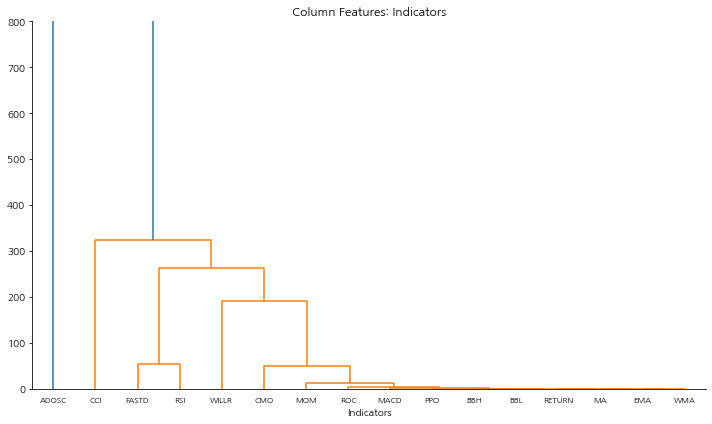

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

labels = sorted(feature_list)
title = 'Column Features: Indicators'
col_order = cluster_features(features.dropna().values.reshape(-1, 16).T,
                             labels,
                             ax,
                             title)

title = 'Row Features: Indicator Parameters'
ax.set_xlabel('Indicators')
ax.set_ylim([0, 800])
sns.despine()
fig.tight_layout()

In [9]:
feature_order = [f'{i}_{j}' for i in features_num for j in col_order]
features = features.loc[:, feature_order]

data_clustered = pd.concat([features, drops], axis=1)
data_clustered.to_csv("data/2.kospi200futures_clustered.csv", index=False)

In [10]:
data_clustered.iloc[:,:16].describe()

,07_ADOSC,07_CCI,07_FASTD,07_RSI,07_WILLR,07_CMO,07_MOM,07_ROC,07_MACD,07_PPO,07_BBH,07_BBL,07_RETURN,07_MA,07_EMA,07_WMA
count,13766.00000,13770.00000,13768.00000,13769.00000,13770.00000,13769.00000,13769.00000,13769.00000,13745.00000,13751.00000,13770.00000,13770.00000,13769.00000,13769.00000,13769.00000,13769.00000
mean,810.12705,2.53207,51.89231,51.21619,-48.10888,2.43237,0.03466,0.01330,-0.00000,0.01209,0.00498,0.00504,0.00013,0.00001,0.00001,0.00001
std,13159.55832,101.81679,26.61900,18.92386,30.08224,37.84772,2.63110,0.85315,1.00004,0.55013,0.00670,0.00602,0.00853,0.00122,0.00122,0.00136
min,-106881.45898,-233.33333,0.57471,3.02358,-100.00000,-93.95283,-20.70000,-9.05493,-6.84840,-5.77471,-0.00431,-0.00785,-0.09055,-0.01352,-0.01455,-0.01468
25%,-6419.41399,-80.39633,28.83947,37.64202,-75.00000,-24.71596,-1.10000,-0.35002,-0.53484,-0.26041,0.00140,0.00146,-0.00350,-0.00050,-0.00047,-0.00052
50%,1014.82160,5.80089,52.18569,51.82468,-47.05882,3.64937,0.05000,0.01704,0.05524,0.04689,0.00300,0.00316,0.00017,0.00002,0.00004,0.00003
75%,7966.36721,85.20391,75.43255,64.87579,-20.77922,29.75158,1.30000,0.40579,0.58774,0.32109,0.00608,0.00649,0.00406,0.00058,0.00054,0.00060
max,76586.14595,233.33333,100.00000,98.01170,-0.00000,96.02341,22.45000,7.65957,6.81930,3.88296,0.11312,0.08396,0.07660,0.01063,0.01147,0.01236
